# Libraries

In [2]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine learning model selection, training, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utility and file handling
import pickle
from os.path import exists

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

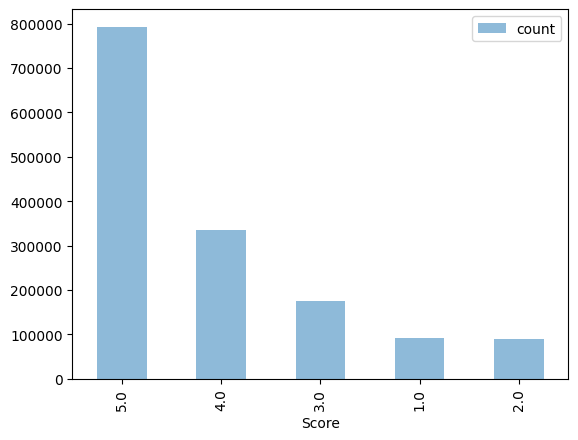


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [4]:
# Deals with preventing memory errors for the next part

from scipy.sparse import vstack
from sklearn.feature_extraction.text import TfidfVectorizer

# Process text data in chunks to avoid memory errors
def process_tfidf_in_chunks(text_series, chunk_size=30000, max_features=450):
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_chunks = []
    
    for start in range(0, len(text_series), chunk_size):
        end = min(start + chunk_size, len(text_series))
        print(f"Processing rows {start} to {end}")
        chunk_tfidf = vectorizer.fit_transform(text_series[start:end])
        tfidf_chunks.append(chunk_tfidf)
        
    return vstack(tfidf_chunks)  # Combines sparse matrices efficiently


# Adding Features

In [5]:
# Import necessary libraries for adding features
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from os.path import exists

# Define a function to add features to a DataFrame
def add_features_to(df):
    # Fill missing values for main features before additional feature engineering
    df['HelpfulnessNumerator'].fillna(0, inplace=True)
    df['HelpfulnessDenominator'].fillna(0, inplace=True)
    df['Time'].fillna(df['Time'].median(), inplace=True)
    df['Text'].fillna("", inplace=True)
    df['Summary'].fillna("", inplace=True)

    # Encode ProductId and UserId for categorical variables
    label_encoder_product = LabelEncoder()
    df['ProductId_encoded'] = label_encoder_product.fit_transform(df['ProductId'])
    df['ProductId_encoded'] = df['ProductId_encoded'].astype('category')  # Convert to category type

    label_encoder_user = LabelEncoder()
    df['UserId_encoded'] = label_encoder_user.fit_transform(df['UserId'])
    df['UserId_encoded'] = df['UserId_encoded'].astype('category')  # Convert to category type

    # Calculate Helpfulness ratio and handle cases where Denominator is 0
    df['Helpfulness'] = np.where(df['HelpfulnessDenominator'] == 0, 0,
                                 df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'])

    # Compute the average score per user as an additional feature
    df['user_avg_score'] = df.groupby('UserId')['Score'].transform('mean')
    df['user_avg_score'] = df['user_avg_score'].fillna(df['Score'].mean())

    # Extract year from the timestamp for time-based analysis
    df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year

    return df

# Check if feature-extracted files already exist
if exists('./data/X_train.csv') and exists('./data/X_submission.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Apply feature engineering to training set
    train = add_features_to(trainingSet)

    # Chunked TF-IDF transformation
    text_tfidf = process_tfidf_in_chunks(train['Text'])

    # Merge TF-IDF features with existing ones
    train = pd.concat([train.reset_index(drop=True), pd.DataFrame(text_tfidf.toarray())], axis=1)
    
    # Merge with test data based on 'Id' to maintain structure for predictions
    X_submission = pd.merge(train, testingSet, on='Id', suffixes=('_train', '_test'))
    X_submission = X_submission.drop(columns=['Score_train'])
    X_submission = X_submission.rename(columns={'Score_test': 'Score'})

    # Separate out rows with available 'Score' values for training
    X_train = train[train['Score'].notna()]

    # Save processed files for reuse
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)


# Sample + Split into training and testing set

In [6]:
# Checking to see Score in columns 
# Check for hidden spaces or formatting issues
print("Column names in X_train:", [f"'{col}'" for col in X_train.columns])

# Strip any unwanted spaces in column names if needed
X_train.columns = X_train.columns.str.strip()

# Now check again
if 'Score' in X_train.columns:
    print("'Score' is present in X_train.")
else:
    print("'Score' is not in X_train.")

# Separate features (X) and target (y) for the main training set
X = X_train.drop(columns=['Score'])  # Ensure 'Score' is excluded from the features
y = X_train['Score']  # Use 'Score' as the target variable

# Split the training set into new training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X,    # Features only
    y,    # Target only
    test_size=0.25,  # Use 25% of data for testing
    random_state=0   # Set random state for reproducibility
)

print("Training and testing sets created successfully.")


Column names in X_train: ["'Id'", "'ProductId'", "'UserId'", "'HelpfulnessNumerator'", "'HelpfulnessDenominator'", "'Time'", "'Summary'", "'Text'", "'Score'", "'ProductId_encoded'", "'UserId_encoded'", "'Helpfulness'", "'user_avg_score'", "'Year'", "'0'", "'1'", "'2'", "'3'", "'4'", "'5'", "'6'", "'7'", "'8'", "'9'", "'10'", "'11'", "'12'", "'13'", "'14'", "'15'", "'16'", "'17'", "'18'", "'19'", "'20'", "'21'", "'22'", "'23'", "'24'", "'25'", "'26'", "'27'", "'28'", "'29'", "'30'", "'31'", "'32'", "'33'", "'34'", "'35'", "'36'", "'37'", "'38'", "'39'", "'40'", "'41'", "'42'", "'43'", "'44'", "'45'", "'46'", "'47'", "'48'", "'49'", "'50'", "'51'", "'52'", "'53'", "'54'", "'55'", "'56'", "'57'", "'58'", "'59'", "'60'", "'61'", "'62'", "'63'", "'64'", "'65'", "'66'", "'67'", "'68'", "'69'", "'70'", "'71'", "'72'", "'73'", "'74'", "'75'", "'76'", "'77'", "'78'", "'79'", "'80'", "'81'", "'82'", "'83'", "'84'", "'85'", "'86'", "'87'", "'88'", "'89'", "'90'", "'91'", "'92'", "'93'", "'94'", "

# Feature Selection

In [9]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
from sklearn.metrics import mean_squared_error

# Define numeric and categorical features only (excluding 'Text' and 'Summary')
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'user_avg_score', 
            'ProductId', 'UserId', 'Year']
print("at features")
# Separate features (X) and target (y) for the main training set
# X = X_train[features]
# y = X_train['Score']

# Split data into train and validation sets
X_train_structured, X_val_structured, y_train, y_val = train_test_split(X[features], y, test_size=0.2, random_state=42)
print("data was split")
# Apply combined label encoding for 'ProductId' and 'UserId'
label_encoder_product = LabelEncoder()
label_encoder_user = LabelEncoder()
print("finished labels")
# Fit on combined data and transform for consistency across training and validation sets
X['ProductId'] = label_encoder_product.fit_transform(X['ProductId'])
print("product id is finally done ")
X['UserId'] = label_encoder_user.fit_transform(X['UserId'])
print("user id is finally done ")

# Transform training and validation sets
X_train_structured['ProductId'] = label_encoder_product.transform(X_train_structured['ProductId'])
print("X_train_structured['ProductId'] done")
X_train_structured['UserId'] = label_encoder_user.transform(X_train_structured['UserId'])
print("X_train_structured['UserId'] done")
X_val_structured['ProductId'] = label_encoder_product.transform(X_val_structured['ProductId'])
print("X_val_structured['ProductId']")
X_val_structured['UserId'] = label_encoder_user.transform(X_val_structured['UserId'])

print("X_val_structured['UserId'] done")
# Gradient Boosting for structured data
model_gb = GradientBoostingRegressor()
print("made model_gb")
model_gb.fit(X_train_structured, y_train)
print("model_gb.fit")
y_pred_gb = model_gb.predict(X_val_structured)
print("y_pred_gb")

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("at tokenizer")
model_bert = BertModel.from_pretrained("bert-base-uncased")
print("model_bert")

# Function to create BERT embeddings in batches
def get_bert_embeddings(text_series, batch_size=64):
    embeddings = []
    for i in range(0, len(text_series), batch_size):
        batch_text = text_series[i:i+batch_size].fillna("")
        inputs = tokenizer(list(batch_text), return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():  # disable gradient computation for inference
            outputs = model_bert(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generate embeddings for train and validation text data in batches
text_embeddings_train = get_bert_embeddings(X_train['Text'], batch_size=256)
print("text_embeddings_train done")
text_embeddings_val = get_bert_embeddings(X_val_structured['Text'], batch_size=256)
print("text_embeddings_val done")
# Combine embeddings with structured features
X_train_hybrid = pd.concat([pd.DataFrame(text_embeddings_train), X_train_structured.reset_index(drop=True)], axis=1)
print("X_train_hybrid")
X_val_hybrid = pd.concat([pd.DataFrame(text_embeddings_val), X_val_structured.reset_index(drop=True)], axis=1)
print("X_val_hybrid ")

# Ensemble training (structured + text embeddings)
final_model = GradientBoostingRegressor()
print("final model")
final_model.fit(X_train_hybrid, y_train)
print("final model fit")
# Evaluation
y_pred_final = final_model.predict(X_val_hybrid)
print("y_pred_final")

# Results
print("Hybrid Model MSE:", mean_squared_error(y_val, y_pred_final))


at features
data was split
finished labels
product id is finally done 
user id is finally done 
X_train_structured['ProductId'] done
X_train_structured['UserId'] done
X_val_structured['ProductId']
X_val_structured['UserId'] done
made model_gb
model_gb.fit
y_pred_gb
at tokenizer
model_bert


KeyboardInterrupt: 

# Model Creation

# Model Evaluation

Accuracy on testing set =  0.3957325300876392


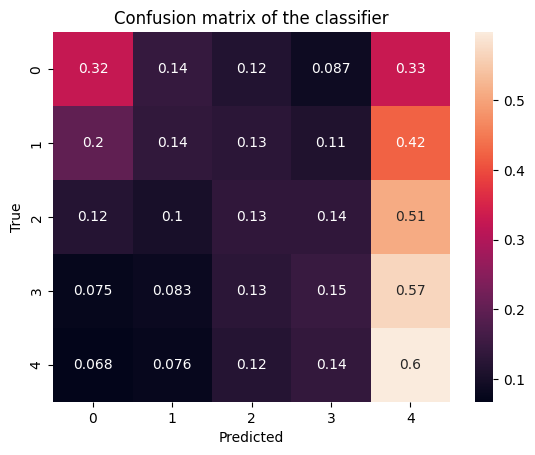

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate using Mean Squared Error for regression
mse = mean_squared_error(y_val, y_pred_final)
r2 = r2_score(y_val, y_pred_final)

print("Hybrid Model Mean Squared Error:", mse)
print("Hybrid Model R-squared:", r2)

# Plotting residuals to visualize the prediction performance
residuals = y_val - y_pred_final
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color="blue", bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of predictions vs actual values for a quick visual check
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred_final, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

# Create submission file

In [8]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)